In [37]:
from ultralytics import YOLO
import cv2
import supervision as sv
import numpy as np
import torch
import math
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from skimage import metrics
import torchvision.transforms as transforms
import lpips
# import subprocess
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = YOLO('/home/nikita/Desktop/diploma/Diploma/models/yolov8n-face.pt')  # load a pretrained YOLOv8n detection model
#model.train(data='coco128.yaml', epochs=3)  # train the model
#model('https://ultralytics.com/images/bus.jpg')  # predict on an image

In [4]:
sam = sam_model_registry["vit_l"](checkpoint="/home/nikita/Desktop/diploma/Diploma/models/sam_vit_l_0b3195.pth").to(device=device)
#predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)
mask_annotator = sv.MaskAnnotator()

In [168]:
image = Image.open('/home/nikita/Desktop/diploma/inference/sample/s2.jpg')

In [169]:
model.task='detect'
results = model.predict(image, imgsz=image.size,
                        save=False,
                        device=device,
                        hide_conf=True, hide_labels=True, conf=0.25, line_width=1)

WARNING ⚠️ 'hide_conf' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_conf' instead.
WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.

0: 1280x1280 1 face, 10.2ms
Speed: 10.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


In [170]:
arr_of_boxes=[]
boxes = results[0].boxes
n=boxes.shape[0]


for i in range(n):
    #     # вот тут надо понять как все же картинку центрировать
    # arr[0] *= 0.95  # сдвиг влево
    # arr[2] *= 0.95
    arr=boxes.xyxy[i].cpu().numpy()
    
    if arr[2]-arr[0] > arr[3]-arr[1]:
        arr[3]=math.ceil(arr[1]+(arr[2]-arr[0]))
    else:
        arr[2]=math.ceil(arr[0]+(arr[3]-arr[1]))

    # arr[:2] *= 0.9
    # arr[-2:] *= 1.1
    
    arr[0]-=(arr[2]-arr[0])*0.3
    # arr[2]+=(arr[2]-arr[0])*0.1
    arr[1]-=(arr[3]-arr[1])*0.15
    arr[3]+=(arr[3]-arr[1])*0.15

    arr_of_boxes.append(arr)

In [171]:
arr_of_box_images=[]
for i in range(n):
    im=image.crop(arr_of_boxes[i])
    x=min(im.size)
    cropped_image = cv2.cvtColor(np.array(im.resize((x, x))), cv2.COLOR_BGR2RGB)
    arr_of_box_images.append(cropped_image)
    # cropped_image.save(f'/home/nikita/Desktop/diploma/inference/sample/sample_{i}.png')

len(arr_of_box_images)

1

In [ ]:
cv2.imshow('im', arr_of_box_images[0])

cv2.waitKey(0)

# Close all windows
cv2.destroyAllWindows()

In [173]:
cv2.imwrite('/home/nikita/Desktop/diploma/inference/res/sample_0_origin.png', arr_of_box_images[0])

True

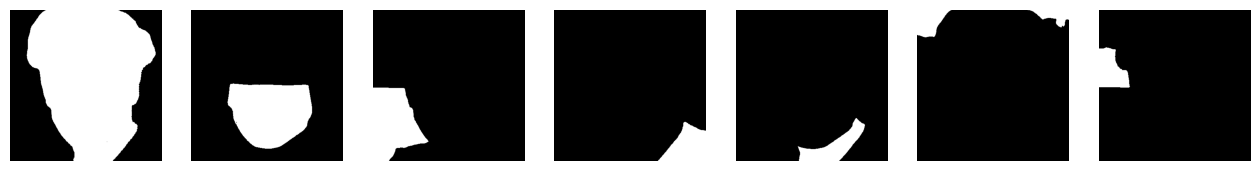

Выберите часть изображения, которую хотите исправить:


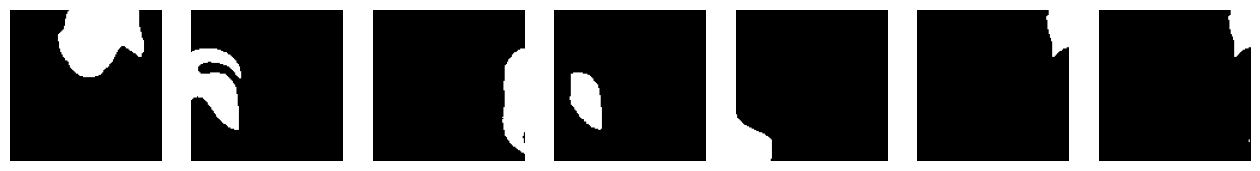

Выберите часть изображения, которую хотите исправить:


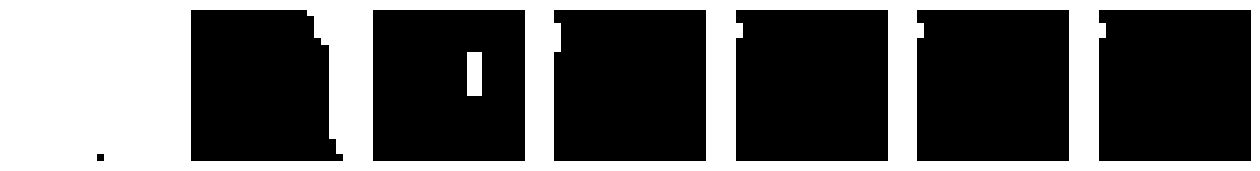

Выберите часть изображения, которую хотите исправить:


In [143]:
for i in range(n):
    image_bgr = arr_of_box_images[i]
    sam_result = mask_generator.generate(image_bgr)
    #detections = sv.Detections.from_sam(sam_result=sam_result)
    #annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]
    sv.plot_images_grid(
    images=masks[:7],
    grid_size=(1, 7),
    size=(16, 16)
    )
    print('Выберите часть изображения, которую хотите исправить:')
    j=int(input())
    _, binary_mask = cv2.threshold(np.uint8(masks[j-1])*255, 127, 255, cv2.THRESH_BINARY)

    cv2.imwrite(f'/home/nikita/Desktop/diploma/inference/image/sample_{i}.png', image_bgr)
    cv2.imwrite(f'/home/nikita/Desktop/diploma/inference/mask/sample_{i}.png', binary_mask)
    

In [39]:
loss_fn = lpips.LPIPS(net='alex')

for i in range(3):
    print(f"Sample #{i}:")
    img1=cv2.imread(f'/home/nikita/Desktop/diploma/norm/image/sample_{i}_origin.png')
    img1 = cv2.resize(img1, (256, 256))
    img1_ten = transforms.ToTensor()(img1)
    for j in range(3):
        img2=cv2.imread(f'/home/nikita/Desktop/diploma/norm/res/sample_{i}_{j}.png')
        print(f"Generated Image #{j}:")
        print("PSNR:", cv2.PSNR(img1, img2))
        print("SSIM:", metrics.structural_similarity(img1, img2, multichannel=True, channel_axis=2))
        print("LPIPS:", loss_fn(img1_ten, transforms.ToTensor()(img2)).item())
    print("\n")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/nikita/miniconda3/envs/dev/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Sample #0:
Generated Image #0:
PSNR: 17.24801010688227
SSIM: 0.5274949440293354
LPIPS: 0.22676637768745422
Generated Image #1:
PSNR: 17.669005398478443
SSIM: 0.5347224030872888
LPIPS: 0.21982474625110626
Generated Image #2:
PSNR: 17.41728833276791
SSIM: 0.530919277778955
LPIPS: 0.21942806243896484


Sample #1:
Generated Image #0:
PSNR: 15.05793262379038
SSIM: 0.5462742297007807
LPIPS: 0.25121161341667175
Generated Image #1:
PSNR: 14.727080988744135
SSIM: 0.5477063917092899
LPIPS: 0.25501903891563416
Generated Image #2:
PSNR: 15.136077437359653
SSIM: 0.5592157402546682
LPIPS: 0.25111687183380127


Sample #2:
Generated Image #0:
PSNR: 16.784716127735923
SSIM: 0.5207893191586619
LPIPS: 0.17269007861614227
Generated Image #1:
PSNR: 16.461658688635875
SSIM: 0.4962452148308507
LPIPS: 0.18395563960075378
Generated

In [25]:
img1=cv2.imread('/home/nikita/Desktop/diploma/norm/image/sample_0_origin.png')
img1 = cv2.resize(img1, (256, 256))
img2=cv2.imread('/home/nikita/Desktop/diploma/norm/res/sample_0_0.png')


In [ ]:
(score, diff) = metrics.structural_similarity(img1, img2, multichannel=True, channel_axis=2)
print("SSIM", score)

In [35]:
from skimage import metrics

ssim = metrics.structural_similarity(img1, img2, multichannel=True, channel_axis=2)

print("SSIM:", metrics.structural_similarity(img1, img2, multichannel=True, channel_axis=2))

SSIM: 0.5274949440293354
